<a href="https://colab.research.google.com/github/sayakpaul/Denoised-Smoothing-TF/blob/main/Train_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and imports

In [1]:
import os
import urllib
from getpass import getpass

user = input('User name: ')
password = getpass('Password: ')
password = urllib.parse.quote(password)
repo_address = input('Repo Address: ')
branch_name = input('Branch name: ')

cmd_string = 'git clone https://{}:{}@github.com/{}.git -b {}'.format(
    user, password, repo_address, branch_name
)

os.system(cmd_string)
cmd_string, password = "", ""

User name: sayakpaul
Password: ··········
Repo Address: sayakpaul/Denoised-Smoothing-TF
Branch name: main


In [1]:
import sys
sys.path.append("Denoised-Smoothing-TF")

from models import resnet20

from tensorflow.keras import layers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
try: 
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: 
    strategy = tf.distribute.MirroredStrategy() 

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.70.187.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.70.187.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


In [3]:
from google.colab import auth
auth.authenticate_user()

## Load the CIFAR-10 dataset

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

Total training examples: 50000
Total test examples: 10000


## Define constants

In [5]:
BATCH_SIZE = 128 * strategy.num_replicas_in_sync
EPOCHS = 200 
START_LR = 0.1 
AUTO = tf.data.AUTOTUNE

## Prepare data loaders

In [6]:
# Augmentation pipeline
simple_aug = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ]
)

# Now, map the augmentation pipeline to our training dataset
train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# Test dataset
test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Model utilities

In [7]:
def lr_schedule(epoch):
    if epoch < int(EPOCHS * 0.25) - 1:
        return START_LR
    elif epoch < int(EPOCHS*0.5) -1:
        return float(START_LR * 0.1)
    elif epoch < int(EPOCHS*0.75) -1:
        return float(START_LR * 0.01)
    else:
        return float(START_LR * 0.001)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_schedule(epoch), verbose=True)

In [8]:
def get_model(n_classes=10):
    n = 2
    depth = n * 9 + 2
    n_blocks = ((depth - 2) // 9) - 1

    # The input tensor
    inputs = layers.Input(shape=(32, 32, 3))
    x = layers.experimental.preprocessing.Rescaling(scale=1.0 / 127.5, offset=-1)(
        inputs
    )

    # The Stem Convolution Group
    x = resnet20.stem(x)

    # The learner
    x = resnet20.learner(x, n_blocks)

    # The Classifier for 10 classes
    outputs = resnet20.classifier(x, 10)

    # Instantiate the Model
    model = tf.keras.Model(inputs, outputs)
    return model

In [9]:
# Serialize the initial model for better reproducibility
with strategy.scope():
    get_model().save("gs://denoised-smoothing-tf/initial_model_resnet20")

INFO:tensorflow:Assets written to: gs://denoised-smoothing-tf/initial_model_resnet20/assets


INFO:tensorflow:Assets written to: gs://denoised-smoothing-tf/initial_model_resnet20/assets


## Model training

In [10]:
# Optimizer and loss function.
optimizer = tf.keras.optimizers.SGD(learning_rate=START_LR, momentum=0.9)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

In [11]:
with strategy.scope():
    rn_model = tf.keras.models.load_model("gs://denoised-smoothing-tf/initial_model_resnet20")
    rn_model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])

history = rn_model.fit(train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=[lr_callback])

Epoch 1/200

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
49/49 [==============================] - 22s 216ms/step - loss: 2.8476 - accuracy: 0.2661 - val_loss: 3.3992 - val_accuracy: 0.1212
Epoch 2/200

Epoch 00002: LearningRateScheduler reducing learning rate to 0.1.
49/49 [==============================] - 3s 47ms/step - loss: 2.2902 - accuracy: 0.4536 - val_loss: 3.9956 - val_accuracy: 0.1086
Epoch 3/200

Epoch 00003: LearningRateScheduler reducing learning rate to 0.1.
49/49 [==============================] - 3s 48ms/step - loss: 2.0309 - accuracy: 0.5288 - val_loss: 4.9698 - val_accuracy: 0.1036
Epoch 4/200

Epoch 00004: LearningRateScheduler reducing learning rate to 0.1.
49/49 [==============================] - 3s 47ms/step - loss: 1.8306 - accuracy: 0.5844 - val_loss: 4.1593 - val_accuracy: 0.1608
Epoch 5/200

Epoch 00005: LearningRateScheduler reducing learning rate to 0.1.
49/49 [==============================] - 3s 48ms/step - loss: 1.6509 - accuracy: 0.

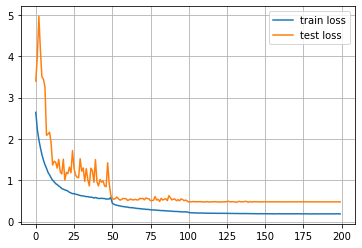

INFO:tensorflow:Assets written to: gs://denoised-smoothing-tf/resnet20_classifier/assets


INFO:tensorflow:Assets written to: gs://denoised-smoothing-tf/resnet20_classifier/assets


In [12]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="test loss")
plt.grid()
plt.legend()
plt.show()

rn_model.save("gs://denoised-smoothing-tf/resnet20_classifier")

In [13]:
with strategy.scope():
    _, train_acc = rn_model.evaluate(train_ds, verbose=0)
    _, test_acc = rn_model.evaluate(test_ds, verbose=0)

print("Train accuracy: {:.2f}%".format(train_acc * 100))
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Train accuracy: 99.06%
Test accuracy: 90.14%
